Copied from 3.3.5, but now testing on a completely different time interval (a Martian half year from the training time interval)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DS_a = xr.open_dataset('af') #dataset of auxhist
DS_w = xr.open_dataset('wf') #dataset of wrfout

In [3]:
#Temperature:
T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
T.shape

(71, 52, 36, 72)

In [4]:
T[5,:,18,0] #temperature goes from lowest height to highest hieght

array([242.71082 , 237.8069  , 236.24007 , 235.12848 , 234.2799  ,
       233.52779 , 232.82172 , 232.14073 , 231.47406 , 230.81564 ,
       229.99742 , 229.01949 , 228.03973 , 227.05513 , 225.73048 ,
       224.05423 , 220.9039  , 215.62561 , 209.97517 , 208.85222 ,
       206.90262 , 204.41917 , 200.12592 , 195.17355 , 189.94121 ,
       186.28903 , 183.58492 , 180.31416 , 176.13753 , 171.68274 ,
       167.32304 , 163.81029 , 160.24342 , 155.59138 , 150.58986 ,
       146.3529  , 142.94057 , 139.79279 , 136.59853 , 133.4877  ,
       131.82347 , 138.27815 , 160.04852 , 173.36342 , 169.7645  ,
       162.5508  , 155.04514 , 147.05397 , 139.96574 , 138.28108 ,
       119.210464, 138.57014 ], dtype=float32)

In [5]:
st = DS_w.TSK.values #surface temp
st.shape

(71, 36, 72)

In [6]:
d_c = DS_w.TAU_OD.values #dust optical depth
d_c.shape 

(71, 52, 36, 72)

In [7]:
em = DS_w.EMISS.values #emissivity
em.shape 

(71, 36, 72)

In [8]:
p = DS_w.P.values + DS_w.PB.values #pressure
p.shape

(71, 52, 36, 72)

In [9]:
uif = DS_a.UPIRFLUX.values[1:,:,:,:] #look at up visual flux on 10th layer
uif.reshape(-1).shape

(9616320,)

In [10]:
temp_uif = []
for i in range(52):
    temp_uif.append(uif[:,i,:,:].reshape(-1))
uif = np.array(temp_uif).T
uif.shape

(181440, 52)

In [11]:
sla = [] #special layer arrays that are the feature vectors in the linear regression model
sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
for i in range(52): #using all the layers now
    sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
for i in range(52): #using all the layers now
    sla.append((np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
sla = np.array(sla)
sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)


In [12]:
sla.shape

(181440, 105)

# Trying linear regression first

In [13]:
from sklearn.linear_model import LinearRegression
uif_out = uif
lr1 = LinearRegression()
lr1.fit(sla,uif_out)
uif_lin = lr1.predict(sla) #predicted

In [14]:
lr1.coef_

array([[ 3.3869480e-08,  2.9351188e-08, -1.1628323e-08, ...,
         2.3613462e-07, -5.3566242e-07,  6.6588168e-06],
       [ 3.3869483e-08,  2.9351039e-08, -1.1628382e-08, ...,
         2.3612569e-07, -5.3567004e-07,  6.6587627e-06],
       [ 3.3869494e-08,  2.9351050e-08, -1.1628202e-08, ...,
         2.3611973e-07, -5.3567794e-07,  6.6587218e-06],
       ...,
       [ 4.2058481e-08,  1.6007963e-08, -6.8057293e-10, ...,
         1.9604649e-07, -5.4032478e-07,  5.2393821e-06],
       [ 4.2364128e-08,  1.6377175e-08, -7.0447559e-10, ...,
         2.0395090e-07, -5.4970087e-07,  5.2431396e-06],
       [ 4.2773120e-08,  1.7074729e-08, -4.1580339e-10, ...,
         2.1293111e-07, -5.5738826e-07,  5.2523515e-06]], dtype=float32)

In [15]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

6.690636

In [16]:
np.min(uif_out)

15.631578

In [17]:
np.max(uif_out)

484.69852

In [18]:
uif_diff = uif_out - uif_lin

In [19]:
np.where(uif_diff == np.min(uif_diff))

(array([87057], dtype=int64), array([27], dtype=int64))

In [20]:
uif_out[92295]

array([147.34494, 147.34497, 147.345  , 147.34517, 147.34552, 147.34624,
       147.34663, 147.3479 , 147.35057, 147.35489, 147.35765, 147.35516,
       147.35257, 147.35507, 147.3633 , 147.37518, 147.38933, 147.4072 ,
       147.43669, 147.4891 , 147.57016, 147.67873, 147.8169 , 147.9991 ,
       148.20267, 148.40678, 148.64833, 148.98164, 149.40726, 149.94196,
       150.74327, 151.89114, 153.23116, 154.60883, 156.00175, 157.42813,
       158.73474, 159.87254, 160.7527 , 161.03299, 161.28531, 161.42572,
       161.54337, 161.64003, 161.71051, 161.73279, 161.73547, 161.72871,
       161.68933, 161.55823, 161.49492, 161.76985], dtype=float32)

In [21]:
uif_lin[92295] #some pretty big differences...

array([175.78532, 175.78537, 175.78546, 175.7854 , 175.78442, 175.7833 ,
       175.78192, 175.78366, 175.78784, 175.79324, 175.79343, 175.78836,
       175.78671, 175.79114, 175.80154, 175.81573, 175.82867, 175.84238,
       175.86374, 175.9078 , 175.98236, 176.0871 , 176.23224, 176.43054,
       176.66022, 176.90735, 177.2112 , 177.63065, 178.15808, 178.83167,
       179.80365, 181.13824, 182.66951, 184.26349, 185.8875 , 187.54782,
       189.1057 , 190.51944, 191.6665 , 192.06429, 192.4562 , 192.69456,
       192.92674, 193.15485, 193.38965, 193.55278, 193.73795, 193.9795 ,
       194.2919 , 194.68845, 195.18819, 195.84045], dtype=float32)

In [22]:
np.where(uif_diff > 50)

(array([], dtype=int64), array([], dtype=int64))

<function matplotlib.pyplot.show(*args, **kw)>

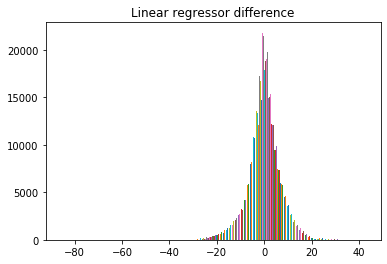

In [23]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [24]:
uif_out.reshape(-1,1).shape

(9434880, 1)

In [25]:
sla[:10*36*72,:].shape

(25920, 105)

In [26]:
sla[10*36*72:11*36*72,:]

array([[3.2982371e+08, 4.3012157e+08, 4.3130067e+08, ..., 2.2520214e+08,
        2.1222704e+08, 2.1280027e+08],
       [3.2989165e+08, 4.3018813e+08, 4.3141155e+08, ..., 2.2847203e+08,
        2.1565395e+08, 2.1283362e+08],
       [3.2991754e+08, 4.3020230e+08, 4.3146352e+08, ..., 2.3201477e+08,
        2.1930179e+08, 2.1278995e+08],
       ...,
       [1.7091520e+09, 1.5555758e+09, 1.5599835e+09, ..., 7.2443635e+08,
        8.0853338e+08, 6.5431699e+08],
       [1.7200332e+09, 1.5640590e+09, 1.5681286e+09, ..., 7.2221261e+08,
        8.0654310e+08, 6.5491136e+08],
       [1.7308575e+09, 1.5723578e+09, 1.5760733e+09, ..., 7.2047450e+08,
        8.0545523e+08, 6.5585107e+08]], dtype=float32)

In [27]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

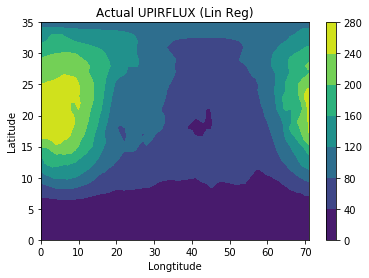

In [28]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

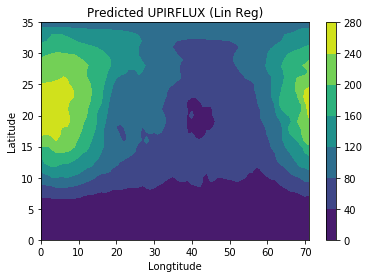

In [29]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

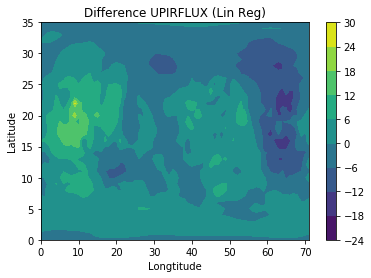

In [30]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

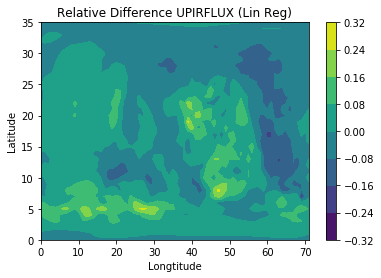

In [31]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [32]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [33]:
real_out.shape

(36, 72)

In [34]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [35]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[1.06852911, 1.03447121, 1.01816561, ..., 0.86853627, 0.70338403,
        0.93283034],
       [1.06846689, 1.03440122, 1.01809808, ..., 0.86845544, 0.70329402,
        0.93273347],
       [1.06808305, 1.03397809, 1.01766966, ..., 0.86805469, 0.70288701,
        0.93230239],
       ...,
       [1.03082315, 1.01623811, 1.02235153, ..., 0.53625862, 0.43506325,
        0.7038968 ],
       [1.03070265, 1.0125767 , 1.01490306, ..., 0.56137732, 0.45715651,
        0.72704615],
       [1.03239783, 1.00778428, 1.00657466, ..., 0.59859069, 0.49022036,
        0.76002416]])

In [36]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([3.58262392, 3.58244928, 3.5823079 , 3.58198701, 3.58209834,
       3.58186949, 3.58213876, 3.58219225, 3.58268147, 3.58225829,
       3.5826725 , 3.58339545, 3.58387155, 3.58555761, 3.58840734,
       3.5932356 , 3.60264289, 3.61463374, 3.62927637, 3.64661221,
       3.66457831, 3.6873693 , 3.71654881, 3.75539954, 3.80464541,
       3.86601246, 3.94317518, 4.03670666, 4.14859972, 4.28508358,
       4.44724469, 4.62722816, 4.81636953, 5.01184943, 5.20839281,
       5.39987989, 5.57104324, 5.71009716, 5.78723283, 5.80266601,
       5.80885573, 5.80856509, 5.80421977, 5.79389029, 5.77507021,
       5.75689951, 5.732964  , 5.70270443, 5.66763207, 5.62456616,
       5.5677382 , 5.48708445])

In [37]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-1.50661623, -1.50676166, -1.50712137, -1.50683159, -1.50668288,
       -1.50678856, -1.5066182 , -1.50680671, -1.50677991, -1.50657206,
       -1.50626269, -1.50620641, -1.50609291, -1.50572836, -1.50552567,
       -1.50672226, -1.50785635, -1.51135784, -1.51715694, -1.52407158,
       -1.53195383, -1.53973167, -1.54893293, -1.55983046, -1.57302475,
       -1.58961496, -1.60869096, -1.63390002, -1.6683906 , -1.71005227,
       -1.75827961, -1.81325402, -1.87657184, -1.95083839, -2.02792964,
       -2.10655605, -2.18304227, -2.24957837, -2.29681726, -2.31302555,
       -2.32670548, -2.33412737, -2.34089169, -2.34648315, -2.35027466,
       -2.35135503, -2.3515357 , -2.35079765, -2.34840599, -2.34308139,
       -2.33399826, -2.31945009])

In [38]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([1.24346539, 1.24344375, 1.24352972, 1.24340479, 1.24346591,
       1.24350882, 1.2435073 , 1.24350999, 1.2435329 , 1.24329779,
       1.2431877 , 1.2431702 , 1.24304857, 1.24333221, 1.24396884,
       1.24530319, 1.24754947, 1.25096668, 1.25582179, 1.26229054,
       1.27008915, 1.27995559, 1.29176599, 1.30549725, 1.32143596,
       1.33990348, 1.36161822, 1.38814054, 1.42135676, 1.4619753 ,
       1.5103363 , 1.56582865, 1.62747474, 1.69462747, 1.76297709,
       1.83015595, 1.89259281, 1.94581641, 1.97897054, 1.98794467,
       1.99448912, 1.99737663, 1.99899823, 1.99880826, 1.99634339,
       1.99322339, 1.9886966 , 1.98237673, 1.97415089, 1.96304937,
       1.94763891, 1.92521834])

In [39]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.47858236, 0.47844852, 0.47813692, 0.47828549, 0.47849028,
       0.47845184, 0.47869938, 0.47854247, 0.47848512, 0.47832892,
       0.47843591, 0.47840873, 0.47820671, 0.47839569, 0.47870904,
       0.47837477, 0.47925217, 0.47943518, 0.47956565, 0.48016538,
       0.48003245, 0.4805357 , 0.48071894, 0.48148826, 0.48226526,
       0.48247652, 0.48254538, 0.48111372, 0.47888689, 0.47728133,
       0.47495621, 0.47195898, 0.46816972, 0.46332533, 0.45811258,
       0.45152908, 0.4438125 , 0.43699193, 0.43266796, 0.43088767,
       0.42925688, 0.42851775, 0.42801357, 0.42767875, 0.42752085,
       0.42755062, 0.42746127, 0.42746512, 0.4280402 , 0.42904221,
       0.43060168, 0.43250848])

In [40]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.4626310444588322


The standard deviation and average are slightly lower than in 3.3.3, so the pressure terms do help the prediction a bit.

# Testing on a different day:

In [41]:
DS_a = xr.open_dataset('af2') #dataset of auxhist 2
DS_w = xr.open_dataset('wf2') #dataset of wrfout 2

T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
st = DS_w.TSK.values #surface temp
d_c = DS_w.TAU_OD.values #dust optical depth
em = DS_w.EMISS.values #emissivity
p = DS_w.P.values + DS_w.PB.values #pressure
uif = DS_a.UPIRFLUX.values[1:,:,:,:] #look at up visual flux on 10th layer

temp_uif = []
for i in range(52):
    temp_uif.append(uif[:,i,:,:].reshape(-1))
uif = np.array(temp_uif).T
uif.shape


sla = [] #special layer arrays that are the feature vectors in the linear regression model
sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
for i in range(52): #using all the layers now
    sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
for i in range(52): #using all the layers now
    sla.append((np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
sla = np.array(sla)
sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)


In [42]:
uif_lin = lr1.predict(sla) #predicted

In [43]:
uif_lin.shape

(619488, 52)

In [44]:
from sklearn.metrics import mean_squared_error
uif_out = uif
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

7.8385725

In [45]:
np.min(uif_out)

15.713927

In [46]:
np.max(uif_out)

484.24545

In [47]:
uif_diff = uif_out - uif_lin

In [48]:
np.where(uif_diff == np.min(uif_diff))

(array([229617], dtype=int64), array([16], dtype=int64))

In [49]:
uif_out[92295]

array([296.89932, 296.899  , 296.89874, 296.89545, 296.89154, 296.89117,
       296.89066, 296.89117, 296.89157, 296.89273, 296.89447, 296.89606,
       296.89697, 296.89944, 296.90714, 296.92184, 296.94623, 296.98248,
       297.03143, 297.0984 , 297.1892 , 297.3129 , 297.4882 , 297.74716,
       298.0995 , 298.54987, 299.12753, 299.87512, 300.78714, 301.84296,
       303.15308, 304.85754, 306.84485, 308.94592, 311.488  , 314.83743,
       318.51923, 322.45288, 325.8706 , 327.21527, 328.61234, 329.48386,
       330.38837, 331.33673, 332.347  , 333.06674, 333.83667, 334.67432,
       335.60754, 336.6833 , 337.9884 , 339.70688], dtype=float32)

In [50]:
uif_lin[92295] #some pretty big differences...

array([284.5219 , 284.52267, 284.523  , 284.51978, 284.51538, 284.51547,
       284.5141 , 284.51437, 284.5166 , 284.51663, 284.51877, 284.52103,
       284.52036, 284.52527, 284.5347 , 284.55475, 284.5755 , 284.60703,
       284.64084, 284.6827 , 284.73676, 284.8122 , 284.94073, 285.16077,
       285.48114, 285.91968, 286.4912 , 287.24295, 288.1599 , 289.2428 ,
       290.5777 , 292.29828, 294.29205, 296.43878, 299.05402, 302.3796 ,
       306.037  , 309.89908, 313.24316, 314.5561 , 315.9207 , 316.7721 ,
       317.65466, 318.58063, 319.5652 , 320.26373, 321.01114, 321.8214 ,
       322.72144, 323.754  , 324.99707, 326.6102 ], dtype=float32)

In [51]:
np.where(uif_diff > 50)

(array([ 37809,  37809,  37809,  37809,  37809,  37809,  37809,  37809,
         37809,  37809,  37809,  37809,  37809,  37809,  37809,  37809,
         37809,  37809,  37809,  37809,  37809,  37809,  37809,  37809,
         37809,  37809,  37809,  37809,  37809,  37809,  37809,  37809,
         37809,  37809,  37809,  37809,  37809,  37809,  37809,  37809,
         37809,  37809,  37809,  37809,  37809,  37809,  37809,  37809,
         37809,  37809,  37809,  37809,  48177,  48177,  48177,  48177,
         48177,  48177,  48177,  48177,  48177,  48177,  48177,  48177,
         48177,  48177,  48177,  48177,  48177,  48177,  48177,  48177,
         48177,  48177,  48177,  48177,  48177,  48177,  48177,  48177,
         48177,  48177,  48177,  48177,  48177,  48177,  48177,  48177,
         48177,  48177,  48177,  48177,  48177,  48177,  48177,  48177,
         48177,  48177,  48177,  48177,  48177,  48177,  48177,  48177,
         58545,  58545,  58545,  58545,  58545,  58545,  58545, 

<function matplotlib.pyplot.show(*args, **kw)>

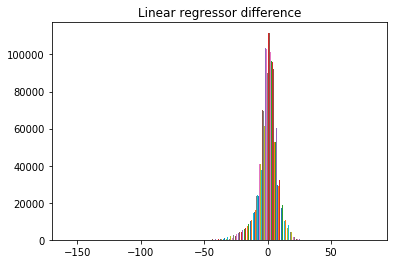

In [52]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [53]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [54]:
sla[:10*36*72,:].shape

(25920, 105)

In [55]:
sla[10*36*72:11*36*72,:]

array([[3.1599933e+08, 4.0962880e+08, 4.0963229e+08, ..., 4.4740090e+08,
        4.3473392e+08, 3.1660086e+08],
       [3.1607878e+08, 4.0981296e+08, 4.0987571e+08, ..., 4.5440250e+08,
        4.3638272e+08, 3.1335379e+08],
       [3.1611712e+08, 4.0996531e+08, 4.1008544e+08, ..., 4.6043094e+08,
        4.3659645e+08, 3.0934269e+08],
       ...,
       [7.1435392e+08, 7.1692192e+08, 7.6333274e+08, ..., 5.3452365e+08,
        5.0600096e+08, 4.2382525e+08],
       [7.1768275e+08, 7.1718816e+08, 7.6268096e+08, ..., 5.3299376e+08,
        5.0774614e+08, 4.2815206e+08],
       [7.2082477e+08, 7.1727558e+08, 7.6174522e+08, ..., 5.3105520e+08,
        5.0898896e+08, 4.3227280e+08]], dtype=float32)

In [56]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

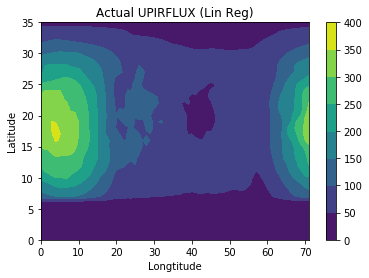

In [57]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

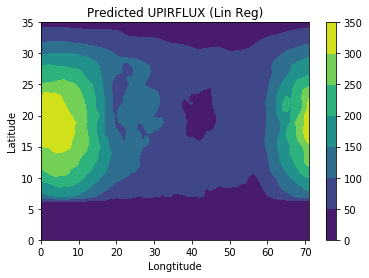

In [58]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

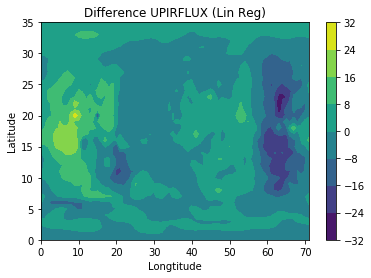

In [59]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

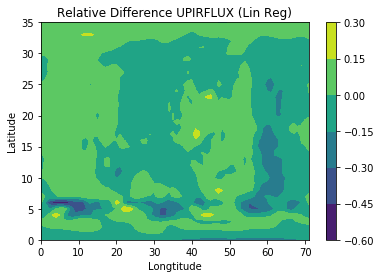

In [60]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [61]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [62]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[-0.25055636, -0.46967729, -0.7062424 , ..., -1.04314824,
         0.06753967, -0.02800951],
       [-0.25070313, -0.46986118, -0.70639378, ..., -1.04335435,
         0.06739861, -0.02818061],
       [-0.25102113, -0.4701237 , -0.70668826, ..., -1.04360073,
         0.06710544, -0.02842657],
       ...,
       [-1.21503727, -2.15441409, -1.556903  , ..., -1.82766972,
        -0.75927556, -1.51099725],
       [-1.16199458, -2.15041088, -1.52481898, ..., -1.77964095,
        -0.70339697, -1.50515771],
       [-1.08884022, -2.13923673, -1.48150456, ..., -1.71066175,
        -0.62999171, -1.49392275]])

In [63]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([ 0.06753967,  0.06739861,  0.06710544,  0.0672585 ,  0.06734943,
        0.06740452,  0.06791565,  0.06802205,  0.06809785,  0.0679714 ,
        0.06780785,  0.06766821,  0.06710518,  0.06656311,  0.06534566,
        0.06288593,  0.06165864,  0.06024437,  0.05928366,  0.05935814,
        0.05882049,  0.05788082,  0.05395095,  0.04547896,  0.03088246,
        0.00799727, -0.02322157, -0.06533451, -0.11772303, -0.17868049,
       -0.25104254, -0.32971266, -0.41386846, -0.5107126 , -0.61472642,
       -0.71868286, -0.80695059, -0.86922584, -0.89594269, -0.90055225,
       -0.90120626, -0.89903245, -0.89472454, -0.88712719, -0.87455463,
       -0.86265783, -0.84742513, -0.82696016, -0.79865598, -0.75927556,
       -0.70339697, -0.62999171])

In [64]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-1.55934684, -1.55955231, -1.55980859, -1.55976419, -1.55973679,
       -1.55990343, -1.55970165, -1.55960821, -1.55927843, -1.55914274,
       -1.55905852, -1.55916382, -1.55967505, -1.5600442 , -1.56090302,
       -1.56304328, -1.56463208, -1.56739448, -1.57076077, -1.57366107,
       -1.57658663, -1.57871644, -1.58253602, -1.58988412, -1.60254912,
       -1.62337635, -1.65215868, -1.69174502, -1.74199882, -1.80283931,
       -1.87516023, -1.95315531, -2.03279367, -2.11895536, -2.20531946,
       -2.29603692, -2.38659789, -2.46218496, -2.5046084 , -2.51412107,
       -2.51927258, -2.52016158, -2.51903536, -2.51498843, -2.50666766,
       -2.49789362, -2.48586828, -2.46945178, -2.44752627, -2.41827806,
       -2.37523713, -2.30972664])

In [65]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.44874056, 0.44875297, 0.44874329, 0.44879403, 0.44884494,
       0.44891553, 0.44901534, 0.44901153, 0.44888674, 0.44875684,
       0.44873291, 0.44881311, 0.44889693, 0.44885938, 0.44873175,
       0.44857529, 0.4485129 , 0.44851252, 0.44862699, 0.44886842,
       0.44903987, 0.44900089, 0.44878273, 0.44827668, 0.44717973,
       0.44573356, 0.44391956, 0.44166721, 0.43914964, 0.43694727,
       0.43438084, 0.43090425, 0.42599667, 0.41976069, 0.41132362,
       0.40379616, 0.40168362, 0.40484053, 0.41085218, 0.41333997,
       0.41576245, 0.41718681, 0.41871095, 0.42040319, 0.42233002,
       0.42386591, 0.42574206, 0.42823768, 0.4317744 , 0.43646897,
       0.44237449, 0.4491536 ])

In [66]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([-0.47910679, -0.47927872, -0.47955377, -0.47942013, -0.47932873,
       -0.47934828, -0.47900372, -0.47902358, -0.47900549, -0.47906224,
       -0.47895682, -0.47901621, -0.47957125, -0.48008508, -0.48110347,
       -0.48338339, -0.48481785, -0.48708224, -0.48951614, -0.49118325,
       -0.4930821 , -0.49467799, -0.49834791, -0.50603035, -0.51998489,
       -0.54261149, -0.57387371, -0.61692617, -0.67123316, -0.73536491,
       -0.81211873, -0.89709673, -0.98710483, -1.08650799, -1.19186208,
       -1.30287887, -1.40876965, -1.49624795, -1.54685908, -1.56044274,
       -1.57002727, -1.57352771, -1.57494344, -1.57308323, -1.56688162,
       -1.56010102, -1.5509714 , -1.53851425, -1.5213077 , -1.49706433,
       -1.46152827, -1.41183746])

In [67]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.8840126192568157
